### Real world tools

1) Database queries
2) API calls (weather , stock prices , etc)
3) File operations 
4) Web searches
5) Send Emails / Notifications 
6) Execute code 
7) Image generation
8) Data analysis

### Agentic patterns


1) Chain of Thoughts (COT)
2) Tree of Thought (TOT)
3) React

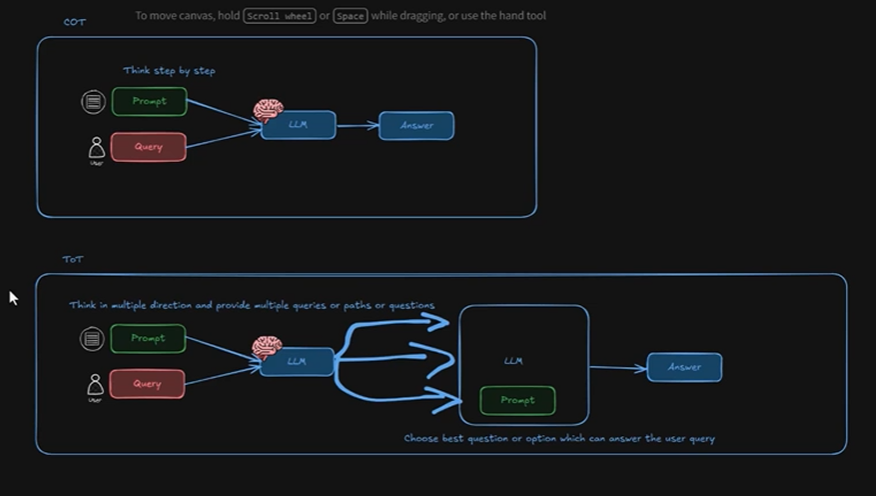

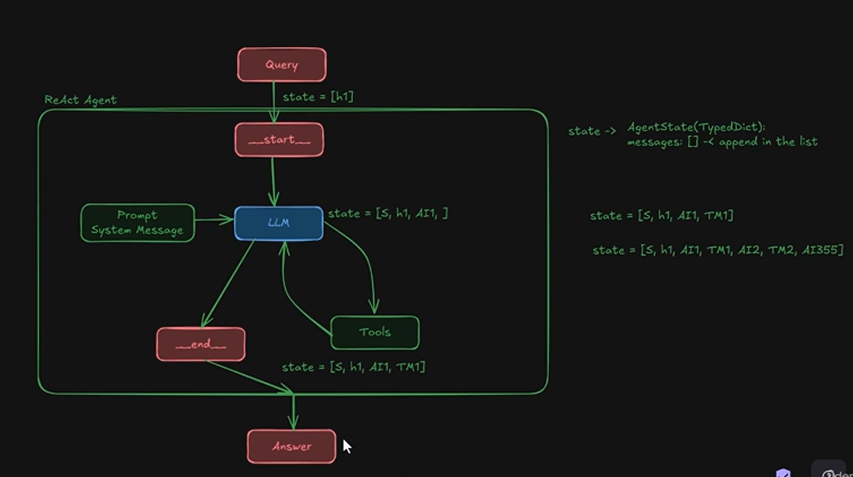

Excellent — you're touching on three *very related but distinct* reasoning paradigms used in **agentic AI** and **LLM orchestration systems** such as LangChain, LangGraph, and ReAct. Let’s unpack each carefully 👇

---

## 🧠 1. **ReAct (Reason + Act) Pattern**

### 🔹 Concept

**ReAct** = **Reasoning + Acting**
It’s a framework that combines **LLM reasoning** (thoughts) with **tool use** (actions).
The model alternates between:

1. Thinking (internal reasoning)
2. Acting (calling a tool, API, or environment)
3. Observing (reading the tool’s result)
4. Thinking again...

### 🔹 Example (LLM reasoning loop)

```
User: What's the population of France times the number of letters in "Paris"?

Thought: I need to look up the population of France.
Action: Search("Population of France")

Observation: Population of France is about 68 million.
Thought: The number of letters in "Paris" is 5.
Answer: 68,000,000 * 5 = 340,000,000
```

So the LLM **reasons** → **acts** → **observes** → **continues**.
This is what frameworks like **LangChain agents** or **LangGraph ReAct agents** are built on.

### 🔹 Typical Structure in LangChain

```python
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool

tools = [
    Tool.from_function(name="Search", func=search_api),
]

agent = initialize_agent(tools, llm, agent_type=AgentType.REACT_DOCSTORE)
response = agent.run("What's the population of France times the number of letters in 'Paris'?")
```

---

## 🌳 2. **Tree of Thoughts (ToT)**

### 🔹 Concept

Tree of Thought = **multiple reasoning paths** rather than one linear chain.

Instead of generating a single line of reasoning, the model **branches into alternative thoughts**, evaluates them, and picks the best path (like a mini search tree).

Think of it as the LLM exploring a **search tree of reasoning paths**, similar to how humans brainstorm and prune ideas.

### 🔹 Process

1. **Thought Generation:** LLM proposes several possible reasoning steps (branches).
2. **State Evaluation:** Each branch is scored (by the LLM or a heuristic).
3. **Search Strategy:**

   * Breadth-first search (explore many options), or
   * Depth-first search (follow one path deeply before backtracking).
4. **Pruning / Selection:** Keep the most promising paths and continue reasoning.

### 🔹 Benefits

* Encourages **divergent thinking**
* Reduces **hallucinations**
* Can solve more complex reasoning tasks (math, planning, logic)

### 🔹 Example (conceptually)

```
Question: How can we get from A to C?
Thought 1: A → B → C
Thought 2: A → D → C
Thought 3: A → E → F → C
Evaluate each path and pick the best.
```

### 🔹 LangGraph implementation (pattern)

You can implement this as a **branching state graph**, where each node represents a reasoning path and returns multiple candidate states.

---

## 🔗 3. **Chain of Thought (CoT)**

### 🔹 Concept

Chain of Thought is the **simplest reasoning pattern** — the model just outputs its internal reasoning steps as text before the final answer.

### 🔹 Example

```
Question: If there are 3 apples and I buy 2 more, how many do I have?

Chain of Thought: There were 3 initially. Buying 2 more adds up to 5 total.
Answer: 5
```

### 🔹 Features

* Linear reasoning (no branching)
* Commonly used implicitly in LLM prompts
* Often hidden in production (e.g., “chain-of-thought reasoning under the hood”)

---

## 🧩 Comparison Table

| Pattern                    | Structure                                | Uses Tools? | Parallelism | Typical Use Case                        |
| -------------------------- | ---------------------------------------- | ----------- | ----------- | --------------------------------------- |
| **Chain of Thought (CoT)** | Linear reasoning                         | ❌           | ❌           | Simple reasoning, math, explanation     |
| **ReAct**                  | Sequential “Reason → Act → Observe” loop | ✅           | ❌           | Agents that need to call APIs/tools     |
| **Tree of Thoughts (ToT)** | Branching reasoning tree                 | Optional    | ✅           | Complex reasoning, planning, creativity |

---

## 🧠 Putting It Together in **Agentic Systems**

Modern agent frameworks like **LangGraph** or **AutoGen** often *combine* these ideas:

* **Chain of Thought**: for transparent reasoning
* **ReAct**: for reasoning + tool use
* **Tree of Thought**: for multi-path reasoning or collaborative agents

For example, a **LangGraph agent** can:

* Use **ReAct** as its execution loop,
* Have **Tree of Thought** branches in the graph structure,
* And use **Chain of Thought** within each node for interpretability.

---

Would you like me to show an **example LangGraph setup** where a ReAct-style agent uses a mini Tree-of-Thought branching node for multi-step reasoning?


In [1]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')

True

In [23]:
from typing_extensions import Literal
import operator
from langgraph.graph import  StateGraph, START, END 
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph.message import add_messages 
from langchain_groq import ChatGroq
from pydantic import BaseModel , Field
import os

In [24]:
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.0,
    max_retries=2,
    api_key=os.getenv("GROQ_API_KEY")
)


The Below Process below is only to maintain history or else we just follow the process which we were doing before

In [25]:
import my_tools
my_tools.get_weather.invoke({"location":"hyderabad"})
my_tools.calculate.invoke({"expression":"12 + 15 * 3*1345.2 - 34 / 345"})

Calculated Result: 60545.90144927536


'60545.90144927536'

In [84]:
all_tools = [my_tools.get_weather , my_tools.calculate]

In [85]:
from typing import Annotated, TypedDict
import operator

class AgentState(TypedDict):
    messages: Annotated[list, operator.add]

In [86]:
def agent_node(state : AgentState):
    llm_with_tools = llm.bind_tools(all_tools)
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return response

In [88]:
state = {"messages" : [
    SystemMessage(content="You are a helpful assistant that can use tools to answer user queries. if city name is given in mixed case, correct it to proper case. and no spaces in weather api location. convert Uppercase to lowercase"),
    HumanMessage(content="What is the weather in New YorK?")
]}
response = agent_node(state)
args = response.additional_kwargs['tool_calls'][0]['function']['arguments']
my_tools.get_weather.invoke({"location":"NewYork"})

{'current_condition': [{'FeelsLikeC': '11',
   'FeelsLikeF': '51',
   'cloudcover': '75',
   'humidity': '83',
   'localObsDateTime': '2025-11-09 03:55 AM',
   'observation_time': '08:55 AM',
   'precipInches': '0.0',
   'precipMM': '0.0',
   'pressure': '1012',
   'pressureInches': '30',
   'temp_C': '12',
   'temp_F': '54',
   'uvIndex': '0',
   'visibility': '14',
   'visibilityMiles': '8',
   'weatherCode': '116',
   'weatherDesc': [{'value': 'Partly cloudy'}],
   'weatherIconUrl': [{'value': ''}],
   'winddir16Point': 'SE',
   'winddirDegree': '126',
   'windspeedKmph': '13',
   'windspeedMiles': '8'}],
 'nearest_area': [{'areaName': [{'value': 'New York'}],
   'country': [{'value': 'United States of America'}],
   'latitude': '40.714',
   'longitude': '-74.006',
   'population': '8107916',
   'region': [{'value': 'New York'}],
   'weatherUrl': [{'value': ''}]}],
 'request': [{'query': 'Lat 40.73 and Lon -73.99', 'type': 'LatLon'}],
 'weather': [{'astronomy': [{'moon_illumination'